### G3 Object Detection 시스템 만들기 

- 목표
    - 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다. 
    - Object detection 모델을 학습할 수 있습니다. 
    - Detection 모델을 활용한 시스템을 만들 수 있습니다. 

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw
import os

#### 1. 데이터 불러오기

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

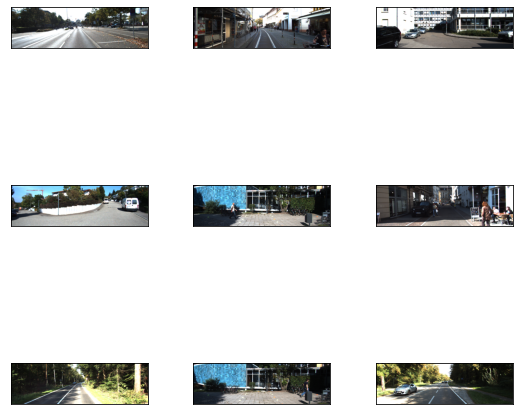

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.56, -0.74,  2.05], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.47959894, 0.43937802, 0.5478075 , 0.4611551 ],
       [0.4152941 , 0.3265832 , 0.548369  , 0.42345718],
       [0.45494652, 0.2655089 , 0.5445455 , 0.32091275]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.48, 1.56, 3.62],
       [1.67, 1.64, 4.32],
       [1.68, 1.67, 4.29]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ -2.65,   0.76,  43.82],
       [ -4.94,   1.24,  26.34],
       [-12.66,   1.12,  38.44]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.63, -0.93,  1.73], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 

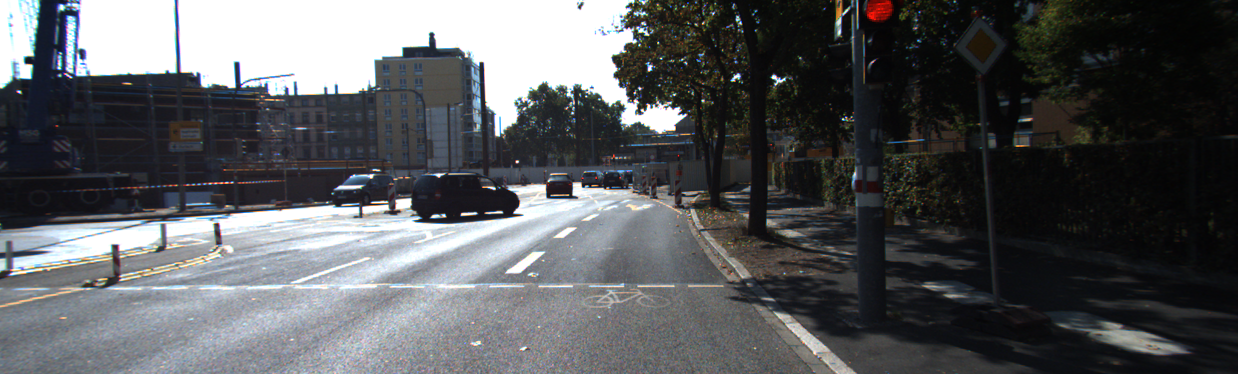

In [6]:
for example in TakeDataset:
    print('--Example--')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

#### 2. Bounding box 그리기

1238 374
(3, 4)
[[543.95    194.62999 570.91    169.12   ]
 [404.31    218.68001 524.24    168.91   ]
 [328.7     203.85    397.28998 170.34   ]]
[543.95    194.62999 570.91    169.12   ]
[404.31    218.68001 524.24    168.91   ]
[328.7     203.85    397.28998 170.34   ]
<PIL.Image.Image image mode=RGB size=1238x374 at 0x7F902444CE90>


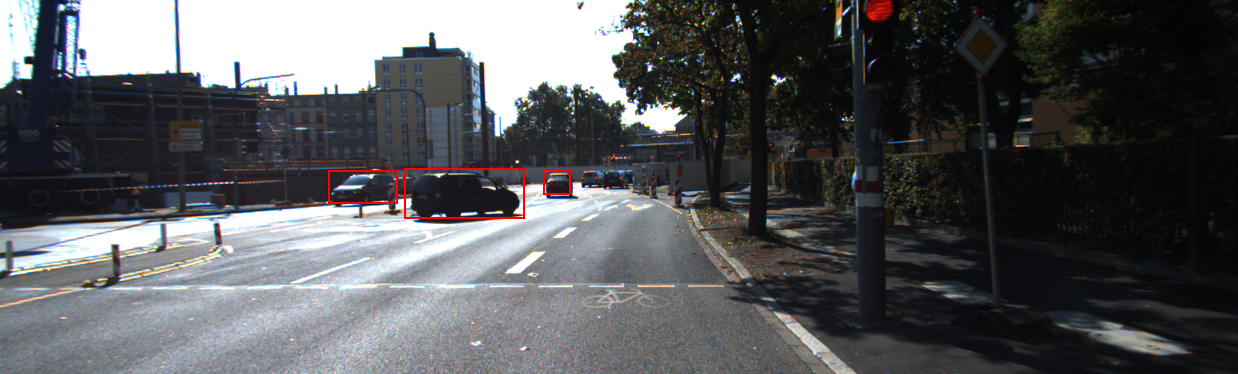

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255, 0, 0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

#### 3. 데이터 포맷 변경

In [8]:
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

In [9]:
def parse_dataset(dataset, img_dir = 'kitti_images', total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
        
    type_class_map = {
        
        0: 'car',
        1: 'car',
        2: 'car',
        3: 'person',
        4: 'person',
        5: 'person',
    }
    
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path":img_path,
                "x1":_rect[0],
                "y1":_rect[1],
                "x2":_rect[2],
                "y2":_rect[3],
                "class_name":type_class_map[_type]
            }, ignore_index=True)
            break
    return df

In [10]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:00<00:00,  8.80it/s]


In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person" : 1,
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

In [12]:
save_class_format(class_txt_path)

#### 4. keras-retinanet 학습

In [13]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt 

2020-11-04 09:35:44.906653: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 09:35:45.924280: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-04 09:35:45.955367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-04 09:35:45.957090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-04 09:35:45.957181: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 09:35:45.962768: I tensorflow/stream_executor/platform

Epoch 1/50
2020-11-04 09:35:53.299499: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-11-04 09:35:54.216060: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-11-04 09:35:54.245225: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-11-04 09:35:54.505932: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-11-04 09:36:09.522641: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
195/

195/195 [==============================] - ETA: 0s - loss: 1.3479 - regression_loss: 1.0506 - classification_loss: 0.2973
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
195/195 [==============================] - 56s 286ms/step - loss: 1.3479 - regression_loss: 1.0506 - classification_loss: 0.2973
Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.2442 - regression_loss: 0.9674 - classification_loss: 0.2768
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 56s 286ms/step - loss: 1.2442 - regression_loss: 0.9674 - classification_loss: 0.2768
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.2374 - regression_loss: 0.9573 - classification_loss: 0.2800
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.2374 - regression_loss: 0.9573 - classification_loss: 0.2800
Epoch 17/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 1.2346 - regression_loss: 0.9485 - classification_loss: 0.2861
Epoch 00030: saving model to ./snapshots/resnet50_csv_30.h5
195/195 [==============================] - 56s 287ms/step - loss: 1.2346 - regression_loss: 0.9485 - classification_loss: 0.2861
Epoch 31/50
195/195 [==============================] - ETA: 0s - loss: 1.2052 - regression_loss: 0.9170 - classification_loss: 0.2882
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
195/195 [==============================] - 56s 289ms/step - loss: 1.2052 - regression_loss: 0.9170 - classification_loss: 0.2882
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 1.2331 - regression_loss: 0.9517 - classification_loss: 0.2814
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 56s 287ms/step - loss: 1.2331 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.1817 - regression_loss: 0.9134 - classification_loss: 0.2684
Epoch 00046: saving model to ./snapshots/resnet50_csv_46.h5
195/195 [==============================] - 56s 287ms/step - loss: 1.1817 - regression_loss: 0.9134 - classification_loss: 0.2684
Epoch 47/50
195/195 [==============================] - ETA: 0s - loss: 1.1481 - regression_loss: 0.8833 - classification_loss: 0.2648
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999424161285e-20.
195/195 [==============================] - 56s 287ms/step - loss: 1.1481 - regression_loss: 0.8833 - classification_loss: 0.2648
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.2215 - regression_loss: 0.9370 - classification_loss: 0.2845
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5
195/195 [==============================] - 57s 291ms/step - loss: 1.2215 - regression_loss:

In [14]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-11-04 10:23:46.559031: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 10:23:47.725819: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-04 10:23:47.759987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-04 10:23:47.761639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-04 10:23:47.761721: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 10:23:47.767379: I tensorflow/stream_executor/platform

In [23]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import keras

from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots','resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


#### 6. 시각화

[592.0313  176.46982 625.9475  206.18918]


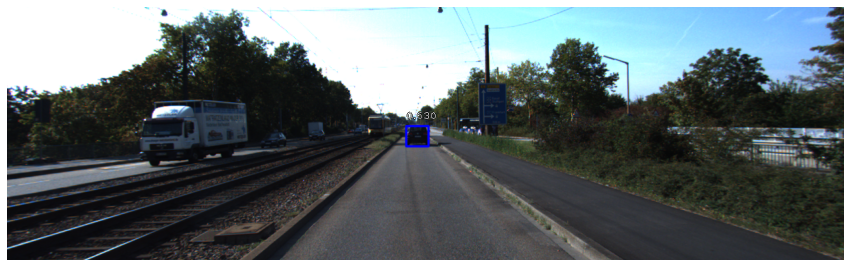

(False, [33.9162], [29.71936])

In [64]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/test_set/go_1.png'

def inference_on_image(model, img_path="./test_set/go_0.png", visualize=True):
    in_person = False
    box_width = []
    box_height = []
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255),
        1: (255, 0, 0),
    }
    
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    boxes /= scale
    
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            
            
            
            if score < 0.4:
                break
            print(box)
            
            if label == 0:    
                box_width.append(box[2] - box[0])
                box_height.append(box[3] -box[1])
            
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            if label == 1:
                in_person = True
            
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
    
    return in_person, box_width, box_height
        
inference_on_image(model, img_path=img_path)

[771.5407  146.95853 838.4037  307.926  ]


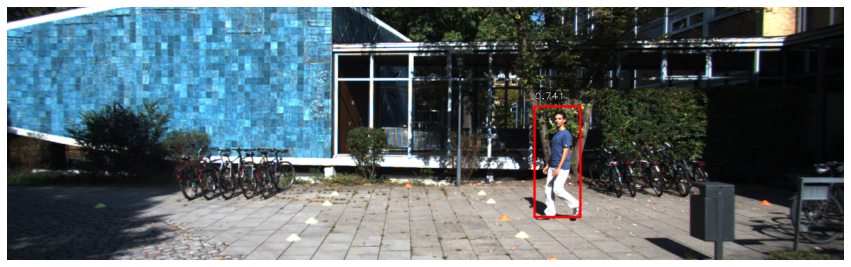

(True, [], [])

In [65]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

#### 7. 자율주행 보조 시스템 만들기 

[ 718.2703     55.456875 1110.7172    373.6249  ]


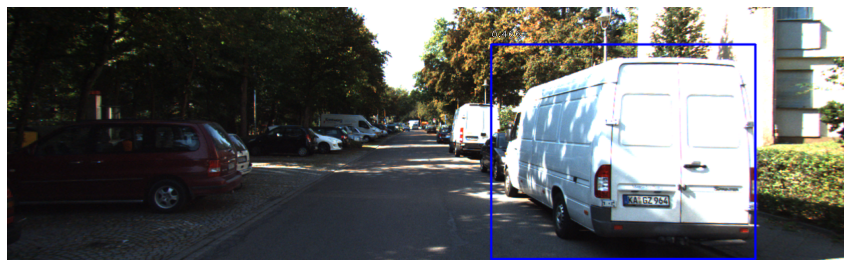

Stop


In [70]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/test_set/stop_4.png'

def self_drive_assist(img_path, size_limit=300):
    
    person, cars_width, cars_height = inference_on_image(model, img_path=img_path)
    
    if person == True:
        return 'Stop'
    
    for car in range(len(cars_width)):
        if cars_width[car] >= size_limit or cars_height[car] >= size_limit:
            return 'Stop'
    
    return 'Go'
    
print(self_drive_assist(img_path))    


[771.5407  146.95853 838.4037  307.926  ]


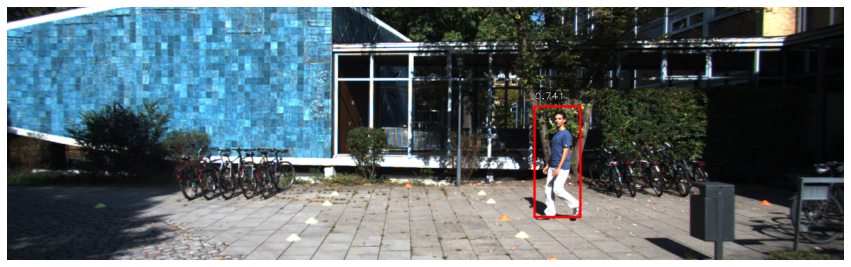

10
[417.50156 155.43692 495.63934 327.0775 ]


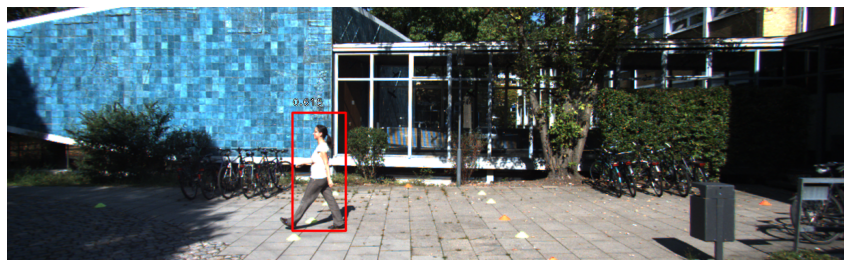

20
[  0.      198.98944 308.84015 369.12827]
[758.2548  164.16249 882.68884 210.617  ]


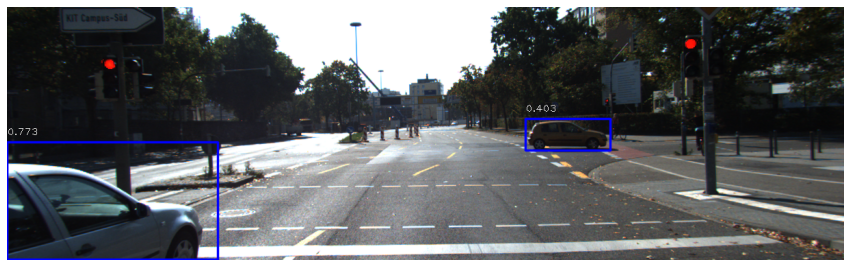

30
[ 718.2703     55.456875 1110.7172    373.6249  ]


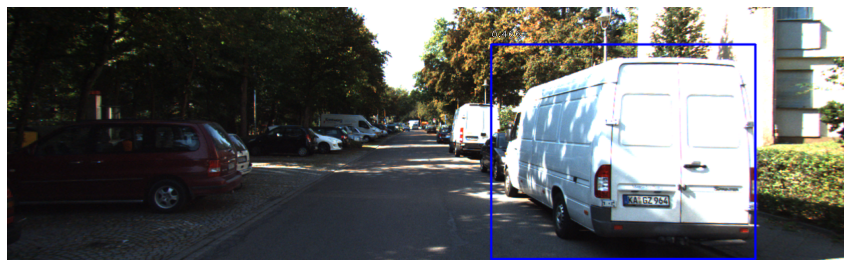

40
[ 886.3911   170.14348 1241.0684   372.6821 ]


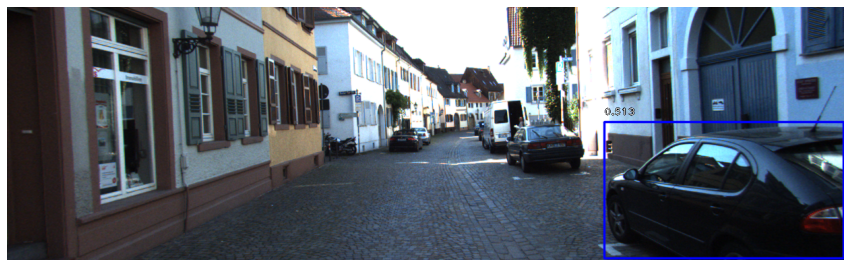

50
[592.0313  176.46982 625.9475  206.18918]


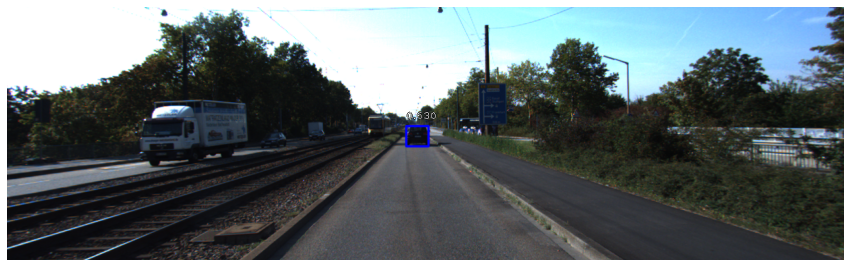

60
[624.95154 176.29263 667.3435  213.11128]


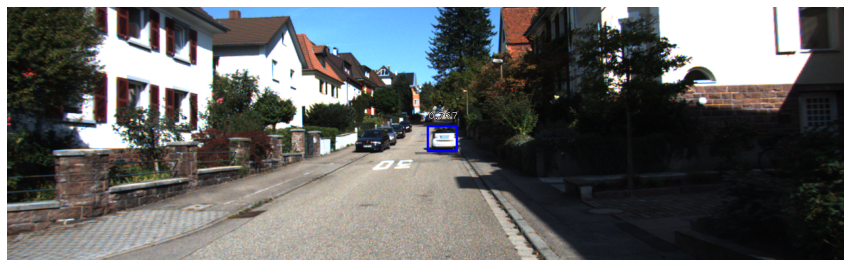

70
[804.0643  146.30121 894.3953  177.96979]


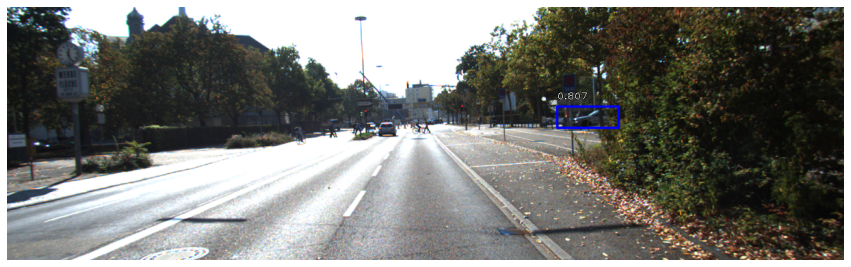

80


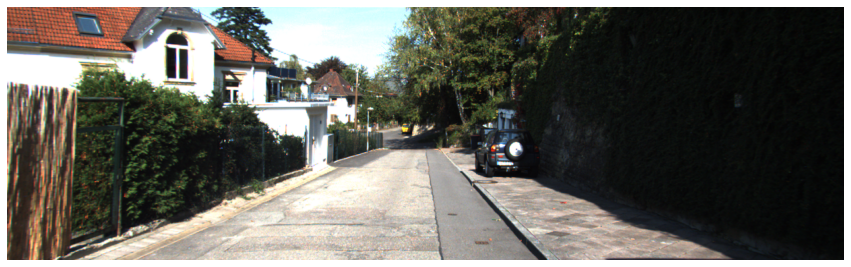

90


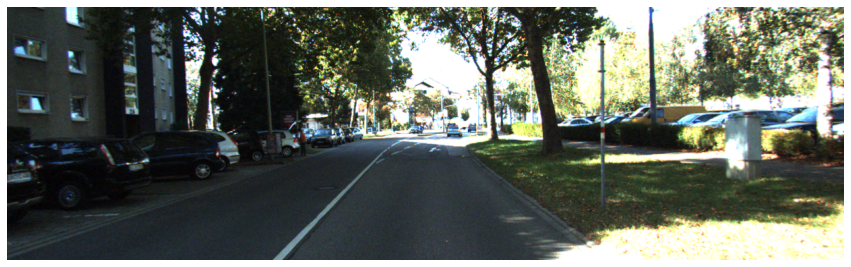

100
100점입니다.


In [69]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
            print(score)
    print(f"{score}점입니다.")

test_system(self_drive_assist)

#### 8. 고찰 

- Object detection을 통해 bounding box를 그리는 방법을 이해하고 해당 값을 활용하는 방법을 고민해 볼 수 있었다. 
- 실제 자율주행에서는 더 많은 요소들과 센서값을 활용하겠지만 기본적인 인식 방법을 실습을 통해 배울 수 있었다. 
- 차선등을 인식할 수 있는 모델을 추가한다면 더 향상된 기능의 보조 시스템을 만들 수 있을 것이라고 생각된다. 